# Etapa 0 - Importação das bibiliotecas e dos Dados

In [34]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import joblib
import warnings
import arff
from plotnine import ggplot, aes, geom_point
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             accuracy_score, f1_score, precision_score, recall_score,
                             roc_curve, precision_recall_curve, average_precision_score)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.metrics import make_scorer
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.utils import resample, class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from kerastuner.tuners import RandomSearch



#Configurações
warnings.filterwarnings('ignore')
plt.style.use('ggplot') # Estilo de plotagem R
pd.set_option('display.max_columns', None) # Mostrar todas as colunas


In [35]:
df_dataset1 = pd.read_csv('datasets/web_page_phishing.csv') # https://www.kaggle.com/datasets/shashwatwork/web-page-phishing-detection-dataset/data

df_dataset2 = pd.read_csv('datasets/phishing_and_benign_websites.csv')  # https://zenodo.org/records/5807622

df_dataset3 = pd.read_csv('datasets/PhiUSIIL_Phishing_URL_Dataset.csv')  # https://archive.ics.uci.edu/dataset/967/phiusiil+phishing+url+dataset

In [36]:
df_dataset3.shape

(235795, 56)

# Etapa 1 - Modelos clássicos com Engenharia de Atributos

Nesta fase, utilizamos variáveis do tipo URL_Length, Having_At_Symbol, Prefix_Suffix, entre outras, disponíveis no dataset “Web Page Phishing Detection Dataset”. 
O objetivo é avaliar como modelos de aprendizado supervisionado tradicionais se comportam com um bom pré-processamento e engenharia de atributos.


## 1.1 Análise Exploratória (EDA)

In [37]:
df = df_dataset1.copy()

In [38]:
# Quantidade de linhas e colunas
df.shape

(11430, 89)

In [39]:
# Primeiros valores do dataset
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,3,0,0,0,0,0,0,4,4,3,3,3,11,11,6,5.750000,7.0,4.500000,0,0,0,0,0,0,17,0.529412,0.470588,0,0,0,0.875000,0,0.500000,0,0,80.000000,0,100.000000,0.000000,0,0,0,0.0,0,0,0,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,0,0,0,0,1,0.220779,0.0,0,0,0,0,0,1,0,0,0,0,1,0,4,4,2,19,2,32,19,32,15.750000,19.0,14.666667,0,0,0,0,0,0,30,0.966667,0.033333,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,80.000000,20.000000,0,0,0,100.0,0,0,0,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,3,2,0,0,5,0,1,0,0,0,0,0,1,0,0,0,0.150794,0.0,0,0,0,1,0,3,1,0,0,0,1,0,12,2,2,3,2,17,13,17,8.250000,8.4,8.142857,0,0,0,0,0,0,4,1.000000,0.000000,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,0.000000,0.000000,0,0,0,100.0,0,0,0,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,1,0,5,5,0,5,5,0,5.000000,5.0,0.000000,0,0,0,0,0,0,149,0.973154,0.026846,0,0,0,0.250000,0,0.250000,0,0,100.000000,0,96.428571,3.571429,0,0,0,62.5,0,0,0,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,6,3,3,3,4,11,7,11,6.333333,5.0,7.000000,0,0,0,0,0,0,102,0.470588,0.529412,0,0,0,0.537037,0,0.018519,1,0,76.470588,0,0.000000,100.000000,0,0,0,0.0,0,0,0,0,1,0,224,8175,8725,0,0,6,legitimate


In [40]:
# Verificando quantidade de valores faltantes
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [41]:
# Variáveis tipo objeto
object_features = [col for col in df.columns if df[col].dtype=="O"]
print(object_features)

['url', 'status']


In [42]:
# Removendo url / label encoding da variável status
df = df.drop(labels='url', axis=1)
if 'status' in df.columns:
        df['status'] = df['status'].apply(lambda x: 1 if 'phish' in str(x).lower() else 0)

df.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,37,19,0,3,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,3,0,0,0,0,0,0,4,4,3,3,3,11,11,6,5.750000,7.0,4.500000,0,0,0,0,0,0,17,0.529412,0.470588,0,0,0,0.875000,0,0.500000,0,0,80.000000,0,100.000000,0.000000,0,0,0,0.0,0,0,0,0,1,0,45,-1,0,1,1,4,0
1,77,23,1,1,0,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,0,0,0,0,1,0.220779,0.0,0,0,0,0,0,1,0,0,0,0,1,0,4,4,2,19,2,32,19,32,15.750000,19.0,14.666667,0,0,0,0,0,0,30,0.966667,0.033333,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,80.000000,20.000000,0,0,0,100.0,0,0,0,1,0,0,77,5767,0,0,1,2,1
2,126,50,1,4,1,0,1,2,0,3,2,0,0,5,0,1,0,0,0,0,0,1,0,0,0,0.150794,0.0,0,0,0,1,0,3,1,0,0,0,1,0,12,2,2,3,2,17,13,17,8.250000,8.4,8.142857,0,0,0,0,0,0,4,1.000000,0.000000,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,0.000000,0.000000,0,0,0,100.0,0,0,0,1,0,0,14,4004,5828815,0,1,0,1
3,18,11,0,2,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,1,0,5,5,0,5,5,0,5.000000,5.0,0.000000,0,0,0,0,0,0,149,0.973154,0.026846,0,0,0,0.250000,0,0.250000,0,0,100.000000,0,96.428571,3.571429,0,0,0,62.5,0,0,0,1,0,0,62,-1,107721,0,0,3,0
4,55,15,0,2,2,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,6,3,3,3,4,11,7,11,6.333333,5.0,7.000000,0,0,0,0,0,0,102,0.470588,0.529412,0,0,0,0.537037,0,0.018519,1,0,76.470588,0,0.000000,100.000000,0,0,0,0.0,0,0,0,0,1,0,224,8175,8725,0,0,6,0


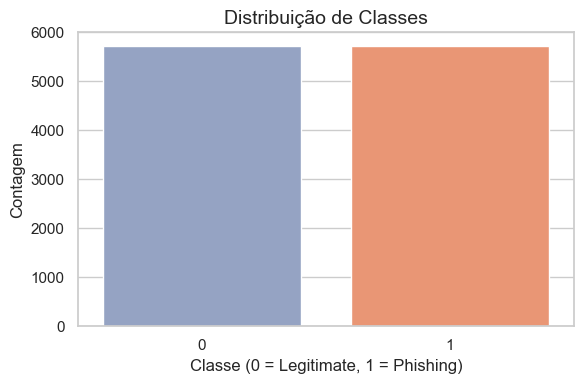

In [43]:
# Distribuição do target
sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(6,4))
sns.countplot(x='status', data=df, palette = ['#8da0cb', '#fc8d62'])
plt.title('Distribuição de Classes', fontsize=14)
plt.xlabel('Classe (0 = Legitimate, 1 = Phishing)', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.tight_layout()
plt.show()

In [44]:
# Proteção da variável target antes dos tratamentos
target_col = 'status'
if target_col in df.columns:
    y = df[target_col].copy()  # Salvar a variável target
    X = df.drop(columns=[target_col])  # Features sem o target
    print(f"Variável target '{target_col}' separada.")
else:
    print(f"ATENÇÃO: Variável target '{target_col}' não encontrada!")

df.head()

Variável target 'status' separada.


,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,37,19,0,3,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,3,0,0,0,0,0,0,4,4,3,3,3,11,11,6,5.750000,7.0,4.500000,0,0,0,0,0,0,17,0.529412,0.470588,0,0,0,0.875000,0,0.500000,0,0,80.000000,0,100.000000,0.000000,0,0,0,0.0,0,0,0,0,1,0,45,-1,0,1,1,4,0
1,77,23,1,1,0,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,0,0,0,0,1,0.220779,0.0,0,0,0,0,0,1,0,0,0,0,1,0,4,4,2,19,2,32,19,32,15.750000,19.0,14.666667,0,0,0,0,0,0,30,0.966667,0.033333,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,80.000000,20.000000,0,0,0,100.0,0,0,0,1,0,0,77,5767,0,0,1,2,1
2,126,50,1,4,1,0,1,2,0,3,2,0,0,5,0,1,0,0,0,0,0,1,0,0,0,0.150794,0.0,0,0,0,1,0,3,1,0,0,0,1,0,12,2,2,3,2,17,13,17,8.250000,8.4,8.142857,0,0,0,0,0,0,4,1.000000,0.000000,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,0.000000,0.000000,0,0,0,100.0,0,0,0,1,0,0,14,4004,5828815,0,1,0,1
3,18,11,0,2,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,1,0,5,5,0,5,5,0,5.000000,5.0,0.000000,0,0,0,0,0,0,149,0.973154,0.026846,0,0,0,0.250000,0,0.250000,0,0,100.000000,0,96.428571,3.571429,0,0,0,62.5,0,0,0,1,0,0,62,-1,107721,0,0,3,0
4,55,15,0,2,2,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,6,3,3,3,4,11,7,11,6.333333,5.0,7.000000,0,0,0,0,0,0,102,0.470588,0.529412,0,0,0,0.537037,0,0.018519,1,0,76.470588,0,0.000000,100.000000,0,0,0,0.0,0,0,0,0,1,0,224,8175,8725,0,0,6,0


Pares com correlação > 0.7:
                     Var1                Var2  Correlação
2538    longest_words_raw   longest_word_path    0.968503
539                nb_and               nb_eq    0.906404
2576    longest_word_host       avg_word_host    0.816313
2465   shortest_word_host       avg_word_host    0.800014
2946  ratio_intHyperlinks       links_in_tags    0.799374
37             length_url    length_words_raw    0.794710
2612    longest_word_path       avg_word_path    0.791198
2539    longest_words_raw       avg_words_raw    0.784753
180                    ip    ratio_digits_url    0.768906
466                 nb_qm               nb_eq    0.731735
2646        avg_words_raw       avg_word_path    0.729817
2541    longest_words_raw       avg_word_path    0.725344
1704    ratio_digits_host  abnormal_subdomain    0.702772
2610    longest_word_path       avg_words_raw    0.701914


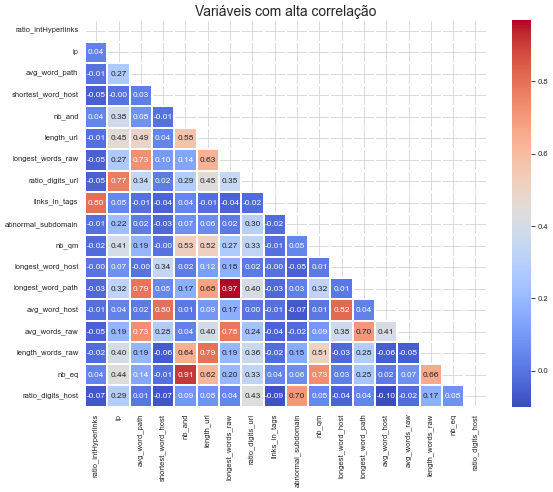

In [45]:
corr_matrix = X.corr().abs() # matriz de correlação das features
high_corr = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
             .stack()
             .reset_index())
high_corr.columns = ['Var1', 'Var2', 'Correlação']
high_corr = high_corr[high_corr['Correlação'] > 0.7].sort_values(by='Correlação', ascending=False)

cols_to_plot = list(set(high_corr['Var1']).union(set(high_corr['Var2'])))
if cols_to_plot:  # Só plotar se houver correlações altas
    corr_matrix1 = X[cols_to_plot].corr()

    # Mostrar os pares
    print("Pares com correlação > 0.7:")
    print(high_corr)

    # Grafico de correlação
    plt.figure(figsize=(12, 10), dpi=50)
    mask = np.triu(np.ones_like(corr_matrix1, dtype=bool))
    sns.heatmap(corr_matrix1, mask=mask, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
    plt.title("Variáveis com alta correlação", fontsize=20)
    plt.tight_layout()
    plt.show()
else:
    print("Nenhuma correlação > 0.7 encontrada.")

In [46]:
# Remoção da variável do par com alta correlação (maior igual a 0.8): manter a primeira variável de cada par
high_corr = high_corr[high_corr['Correlação']>=0.8]

to_drop = set()
for _, row in high_corr.iterrows():
    if row['Var1'] not in to_drop:
        to_drop.add(row['Var2'])

# Remover as variáveis selecionadas das features (X)
X_reduced = X.drop(columns=to_drop) if to_drop else X.copy()
print(f"Variáveis removidas por alta correlação: {to_drop}")

Variáveis removidas por alta correlação: {'nb_eq', 'longest_word_path', 'avg_word_host'}


Variáveis com alta cardinalidade (>50 valores únicos):
- web_traffic: 4744 valores únicos (Tipo: int64)
- domain_age: 4430 valores únicos (Tipo: int64)
- ratio_extHyperlinks: 3131 valores únicos (Tipo: float64)
- ratio_intHyperlinks: 3131 valores únicos (Tipo: float64)
- domain_registration_length: 1659 valores únicos (Tipo: int64)
- ratio_digits_url: 1414 valores únicos (Tipo: float64)
- safe_anchor: 1083 valores únicos (Tipo: float64)
- avg_words_raw: 896 valores únicos (Tipo: float64)
- ratio_extRedirection: 894 valores únicos (Tipo: float64)
- avg_word_path: 757 valores únicos (Tipo: float64)
- nb_hyperlinks: 691 valores únicos (Tipo: int64)
- ratio_extErrors: 635 valores únicos (Tipo: float64)
- ratio_intMedia: 490 valores únicos (Tipo: float64)
- ratio_extMedia: 490 valores únicos (Tipo: float64)
- links_in_tags: 473 valores únicos (Tipo: float64)
- length_url: 324 valores únicos (Tipo: int64)
- ratio_digits_host: 241 valores únicos (Tipo: float64)
- longest_words_raw: 119 valore

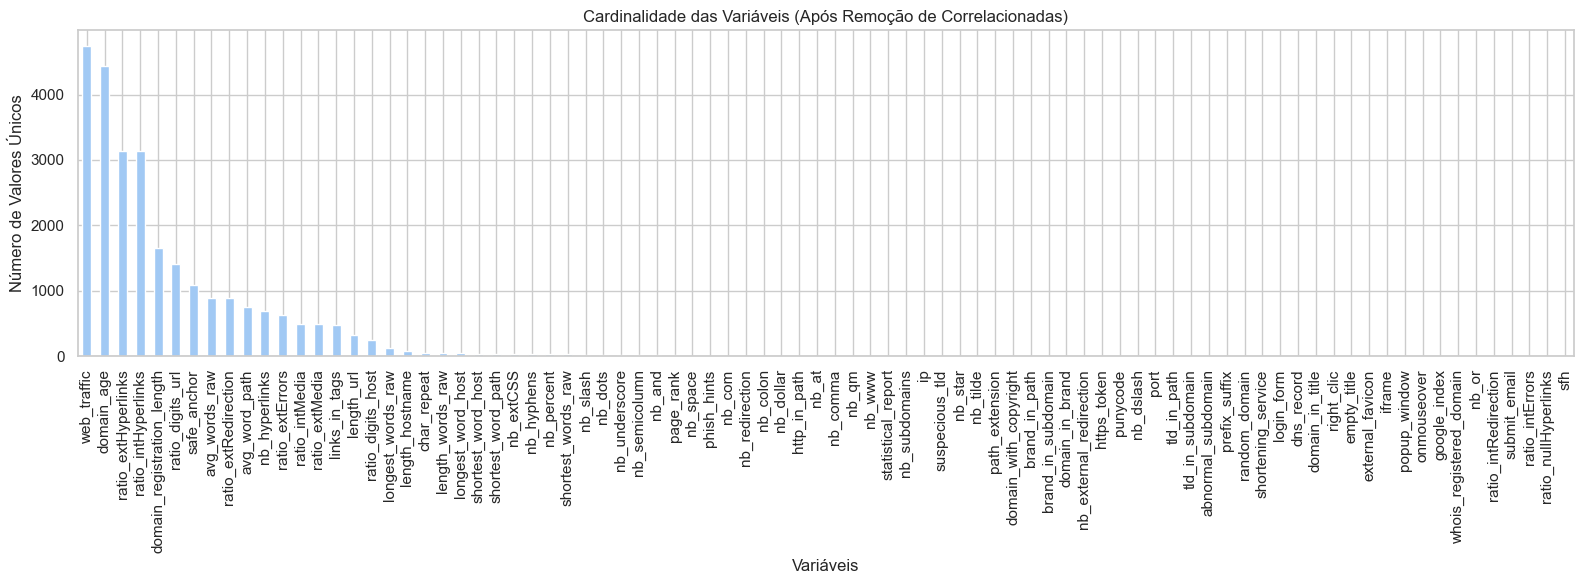

In [47]:
# Calcular cardinalidade após remoção
cardinality = X_reduced.nunique().sort_values(ascending=False)

# Filtrar variáveis com alta cardinalidade
high_card_cols = cardinality[cardinality > 50].index.tolist()
high_card_values = cardinality[cardinality > 50]

print("Variáveis com alta cardinalidade (>50 valores únicos):")
for col, nunique in high_card_values.items():
    dtype = X_reduced[col].dtype
    print(f"- {col}: {nunique} valores únicos (Tipo: {dtype})")

# Gráfico de cardinalidade
plt.figure(figsize=(16, 6))
cardinality.plot(kind='bar')
plt.title('Cardinalidade das Variáveis (Após Remoção de Correlacionadas)')
plt.ylabel('Número de Valores Únicos')
plt.xlabel('Variáveis')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [48]:
# Tratamento para alta cardinalidade
for col in high_card_cols:
    # Contagem de valores antes do tratamento
    original_counts = X_reduced[col].nunique()
    
    # Binagem em 5 categorias usando quantis
    try:
        X_reduced[col] = pd.qcut(X_reduced[col], q=5, duplicates='drop', labels=False)
        new_counts = X_reduced[col].nunique()
        print(f"» {col}: Reduzido de {original_counts} para {new_counts} bins")
    except ValueError as e:
        print(f"» {col}: Não foi possível aplicar binagem - {str(e)}")
        # Alternativa: Transformação logarítmica para distribuições assimétricas
        if (X_reduced[col] > 0).all():
            X_reduced[col] = np.log1p(X_reduced[col])
            print(f"   Aplicada transformação logarítmica alternativa")

» web_traffic: Reduzido de 4744 para 4 bins
» domain_age: Reduzido de 4430 para 5 bins
» ratio_extHyperlinks: Reduzido de 3131 para 4 bins
» ratio_intHyperlinks: Reduzido de 3131 para 5 bins
» domain_registration_length: Reduzido de 1659 para 5 bins
» ratio_digits_url: Reduzido de 1414 para 3 bins
» safe_anchor: Reduzido de 1083 para 4 bins
» avg_words_raw: Reduzido de 896 para 5 bins
» ratio_extRedirection: Reduzido de 894 para 3 bins
» avg_word_path: Reduzido de 757 para 4 bins
» nb_hyperlinks: Reduzido de 691 para 5 bins
» ratio_extErrors: Reduzido de 635 para 2 bins
» ratio_intMedia: Reduzido de 490 para 2 bins
» ratio_extMedia: Reduzido de 490 para 2 bins
» links_in_tags: Reduzido de 473 para 3 bins
» length_url: Reduzido de 324 para 5 bins
» ratio_digits_host: Reduzido de 241 para 1 bins
» longest_words_raw: Reduzido de 119 para 5 bins
» length_hostname: Reduzido de 83 para 5 bins
» char_repeat: Reduzido de 55 para 4 bins
» length_words_raw: Reduzido de 54 para 5 bins


In [49]:
# Removendo variáveis com apenas 1 valor único (constantes)
const_cols  = [col for col in X_reduced.columns if X_reduced[col].nunique() == 1]
X_reduced = X_reduced.drop(columns=const_cols)


Cardinalidade após tratamento:
longest_word_host          49
shortest_word_host         34
shortest_word_path         33
nb_extCSS                  33
nb_hyphens                 27
                           ..
onmouseover                 2
domain_with_copyright       2
whois_registered_domain     2
dns_record                  2
google_index                2
Length: 77, dtype: int64


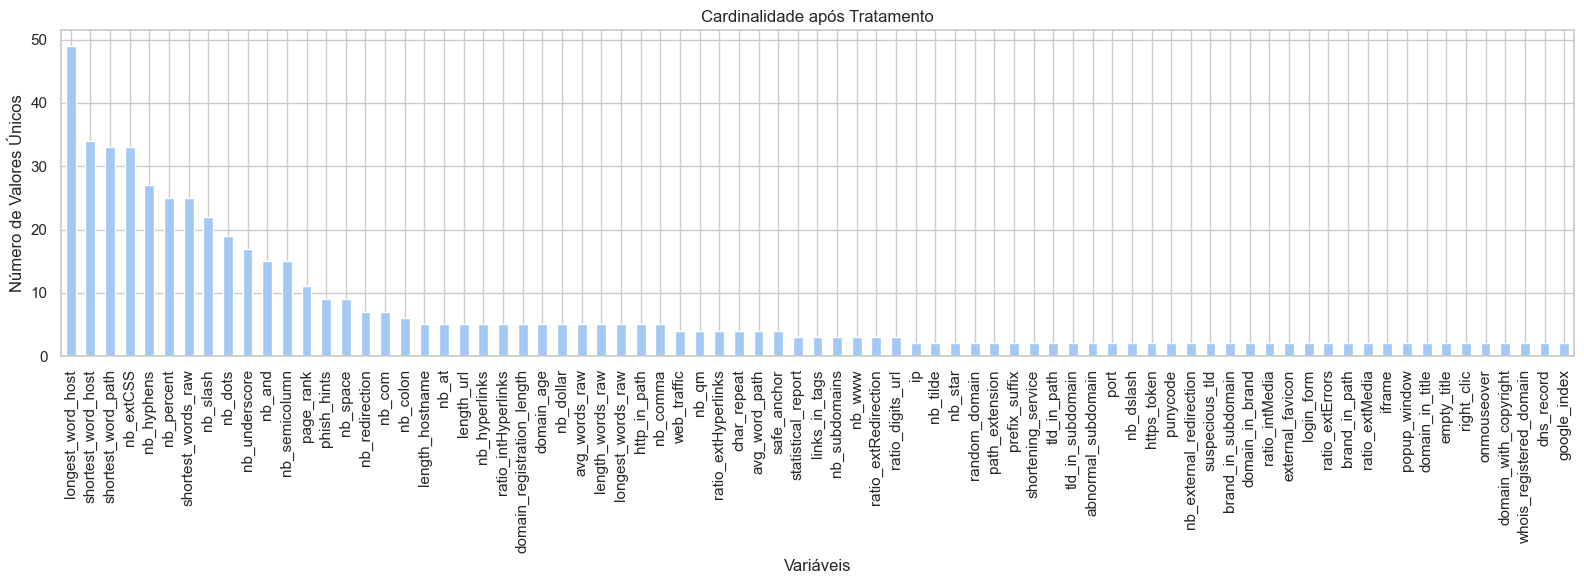

In [50]:
# Nova verificação de cardinalidade
final_cardinality = X_reduced.nunique().sort_values(ascending=False)
print("\nCardinalidade após tratamento:")
print(final_cardinality[final_cardinality > 1])  # Mostrar apenas colunas não-constantes

plt.figure(figsize=(16, 6))
final_cardinality.plot(kind='bar')
plt.title('Cardinalidade após Tratamento')
plt.ylabel('Número de Valores Únicos')
plt.xlabel('Variáveis')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [51]:
# Recombinação: Juntar features tratadas com o target
df_reduced = X_reduced.copy()
df_reduced[target_col] = y  # Adicionar a variável target novamente

print(f"Dataset final: {df_reduced.shape}")
print(f"Variável target '{target_col}' preservada com {df_reduced[target_col].nunique()} classes únicas")
print(f"Distribuição do target:")
print(df_reduced[target_col].value_counts())

df_reduced.head()

Dataset final: (11430, 78)
Variável target 'status' preservada com 2 classes únicas
Distribuição do target:
status
0    5715
1    5715
Name: count, dtype: int64


,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,avg_words_raw,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,nb_extCSS,ratio_extRedirection,ratio_extErrors,login_form,external_favicon,links_in_tags,ratio_intMedia,ratio_extMedia,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,1,2,0,3,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,3,0,0,0,0,0,0,1,2,3,3,3,2,11,1,1,0,0,0,0,0,0,1,1,2,0,2,1,0,0,2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,4,0
1,3,3,1,1,0,0,0,0,0,0,0,5,0,1,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,1,0,0,0,0,1,0,1,2,2,19,2,4,19,4,3,0,0,0,0,0,0,2,3,0,0,0,0,0,0,2,1,0,0,0,3,0,0,0,1,0,0,1,3,0,0,1,2,1
2,4,4,1,4,1,0,1,2,2,0,0,5,0,1,0,0,0,0,0,1,0,0,0,2,0,0,0,1,0,3,1,0,0,0,1,0,4,0,2,3,2,3,13,3,3,0,0,0,0,0,0,0,4,0,0,0,0,0,0,2,0,0,0,0,3,0,0,0,1,0,0,0,2,3,0,1,0,1
3,0,0,0,2,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,5,5,0,0,5,0,0,0,0,0,0,0,0,4,4,0,0,1,1,0,0,2,1,0,0,0,2,0,0,0,1,0,0,1,0,2,0,0,3,0
4,2,1,0,2,2,0,0,0,0,0,0,5,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,1,0,2,1,3,3,4,2,7,2,2,0,0,0,0,0,0,3,1,2,0,2,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,2,4,1,0,0,6,0


## 1.2 Pré-processamento

In [52]:
# Separar features e target
X= df_reduced.iloc[: , 0:-1]
Y= df_reduced['status']

In [53]:
# Separar variáveis binárias
binary_cols = [col for col in X.columns if X[col].nunique() == 2]
non_binary_cols = [col for col in X.columns if col not in binary_cols]

# Escalar apenas as não-binárias
scaler = StandardScaler()
X_scaled_non_binary = pd.DataFrame(scaler.fit_transform(X[non_binary_cols]), columns=non_binary_cols)

# Concatenar com as binárias
X_scaled = pd.concat([X_scaled_non_binary, X[binary_cols]], axis=1)


<Figure size 1400x800 with 0 Axes>

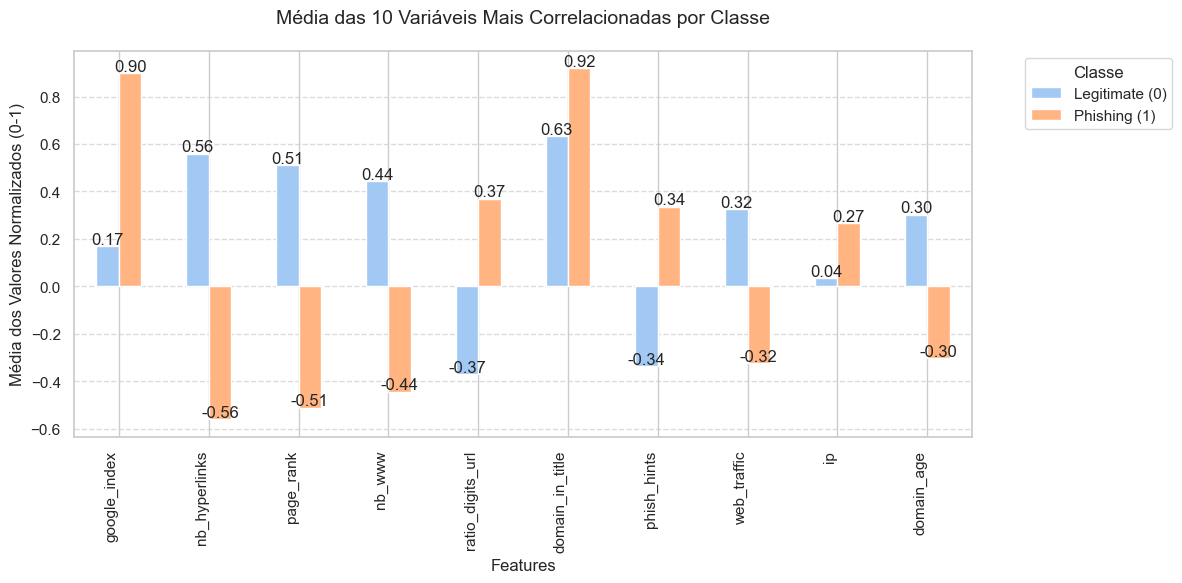

In [54]:
# Visualização das Médias das Features por Classe (Status)

# Criar cópia dos dados normalizados e adicionar a variável target
X_scaled_with_status = X_scaled.copy()
X_scaled_with_status['status'] = y.values

# Selecionar as 10 variáveis mais correlacionadas com o target
top10_corr = X_scaled.corrwith(y).abs().sort_values(ascending=False).head(10)
cols = top10_corr.index.tolist()
cols.append('status')  # Adicionar a coluna status para o groupby

# Calcular a média de cada feature para cada classe
df_grouped = X_scaled_with_status[cols].groupby('status').mean().T
df_grouped.columns = ['Legitimate (0)', 'Phishing (1)']

# Plotar o gráfico de barras comparativo
plt.figure(figsize=(14, 8))
ax = df_grouped.plot(kind='bar', figsize=(12,6))
ax.set_title("Média das 10 Variáveis Mais Correlacionadas por Classe", fontsize=14, pad=20)
ax.set_xlabel("Features", fontsize=12)
ax.set_ylabel("Média dos Valores Normalizados (0-1)", fontsize=12)
ax.legend(title='Classe', bbox_to_anchor=(1.05, 1), loc='upper left')

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.xticks(rotation=90, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## 1.3 Divisão dos Dados

In [55]:
#  Treino (60%): ajuste do modelo
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.4, random_state=1, stratify=y
)

# Validação (20%): Ajuste dos hiperparâmetros
# Teste (20%): Avaliação da performance no final
X_val, X_test_final, y_val, y_test_final = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp
)

print(f"Treino: {X_train.shape}")
print(f"Validação: {X_val.shape}")
print(f"Teste: {X_test_final.shape}")

Treino: (6858, 77)
Validação: (2286, 77)
Teste: (2286, 77)


In [56]:
# Verificar distribuição das classes em cada conjunto
print("\nDistribuição das classes:")
print(f"Treino - Classe 0: {(y_train==0).sum()} ({(y_train==0).mean():.2%}), Classe 1: {(y_train==1).sum()} ({(y_train==1).mean():.2%})")
print(f"Validação - Classe 0: {(y_val==0).sum()} ({(y_val==0).mean():.2%}), Classe 1: {(y_val==1).sum()} ({(y_val==1).mean():.2%})")
print(f"Teste - Classe 0: {(y_test_final==0).sum()} ({(y_test_final==0).mean():.2%}), Classe 1: {(y_test_final==1).sum()} ({(y_test_final==1).mean():.2%})")


Distribuição das classes:
Treino - Classe 0: 3429 (50.00%), Classe 1: 3429 (50.00%)
Validação - Classe 0: 1143 (50.00%), Classe 1: 1143 (50.00%)
Teste - Classe 0: 1143 (50.00%), Classe 1: 1143 (50.00%)


## 1.4 Treinamento com Modelos 

In [57]:
# Dicionário para armazenar os modelos e resultados
models = {}
results = {}


def evaluate_model(model, X, y, model_name):
    """
    Avalia um modelo e retorna métricas de performance
    """
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    }

    scores = cross_validate(model, X, y, scoring=scoring, cv=5, return_train_score=True)
    
    metrics = {
        'train_accuracy': scores['train_accuracy'].mean(),
        'val_accuracy': scores['test_accuracy'].mean(),
        'train_precision': scores['train_precision'].mean(),
        'val_precision': scores['test_precision'].mean(),
        'train_recall': scores['train_recall'].mean(),
        'val_recall': scores['test_recall'].mean(),
        'train_f1': scores['train_f1'].mean(),
        'val_f1': scores['test_f1'].mean(),
        'train_auc': scores['train_roc_auc'].mean(),
        'val_auc': scores['test_roc_auc'].mean(),
    }
    
    return metrics


In [58]:
# Logistic Regression
print("Treinando Logistic Regression")
lr_model = LogisticRegression(random_state=1, max_iter=1000)
models['Logistic Regression'] = lr_model
results['Logistic Regression'] = evaluate_model(lr_model, X_train, y_train, 'Logistic Regression')
print("Logistic Regression concluído")

Treinando Logistic Regression
Logistic Regression concluído


In [ ]:
# K-Nearest Neighbors (KNN)
print("Treinando KNN")
knn_model = KNeighborsClassifier(n_neighbors=5)
models['KNN'] = knn_model
results['KNN'] = evaluate_model(knn_model, X_train, y_train, 'KNN')
print("KNN concluído")


Treinando KNN


In [ ]:
# Random Forest
print("Treinando Random Forest")
rf_model = RandomForestClassifier(
    n_estimators=100, # número de árvores na floresta (padrão: 100)
    random_state=1,
    n_jobs=-1
)
models['Random Forest'] = rf_model
results['Random Forest'] = evaluate_model(rf_model, X_train, y_train, 'Random Forest')
print("Random Forest concluído")

Treinando Random Forest
Random Forest concluído


In [ ]:
# XGBoost
print("Treinando XGBoost")
xgb_model = XGBClassifier(
    random_state=1,
    eval_metric='logloss',  #  métrica de avaliação usada durante o treino ('logloss' para classificação binária)
    verbosity=0
)
models['XGBoost'] = xgb_model
results['XGBoost'] = evaluate_model(xgb_model, X_train, y_train, 'XGBoost')
print("XGBoost concluído")

Treinando XGBoost
XGBoost concluído


In [ ]:
# Support Vector Machine
print("Treinando SVM")
svm_model = SVC(
    random_state=1,
    probability=True  # Para obter probabilidades
)
models['SVM'] = svm_model
results['SVM'] = evaluate_model(svm_model, X_train, y_train, 'SVM')
print("SVM concluído")

Treinando SVM
SVM concluído


In [ ]:
lgb_model = lgb.LGBMClassifier(
    random_state=1,
    verbose=-1,
    n_jobs=-1)
models['LightGBM'] = lgb_model
results['LightGBM'] = evaluate_model(lgb_model, X_train, y_train, 'LightGBM')
print("LightGBM concluído")


LightGBM concluído


In [ ]:
# Rede Neural com uma camada intermediárias com 100 neurônios
mlp_model = MLPClassifier(hidden_layer_sizes=(100, ), max_iter=500, random_state=1)
models['MLP'] = mlp_model
results['MLP'] = evaluate_model(mlp_model, X_train, y_train, 'MLP')
print("MLP concluído")


MLP concluído


In [ ]:
# Rede Neural com duas camadas intermediárias com 100 e 50 neurônios
mlp_model1 = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500,  early_stopping=False, verbose=True, random_state=1)
models['MLP1'] = mlp_model1
results['MLP1'] = evaluate_model(mlp_model1, X_train, y_train, 'MLP1')
print("MLP1 concluído")

Iteration 1, loss = 0.47369178
Iteration 2, loss = 0.24362102
Iteration 3, loss = 0.17563561
Iteration 4, loss = 0.14718324
Iteration 5, loss = 0.12982957
Iteration 6, loss = 0.11813028
Iteration 7, loss = 0.10988516
Iteration 8, loss = 0.10351698
Iteration 9, loss = 0.09781874
Iteration 10, loss = 0.09272472
Iteration 11, loss = 0.08721946
Iteration 12, loss = 0.08398202
Iteration 13, loss = 0.07908549
Iteration 14, loss = 0.07584901
Iteration 15, loss = 0.07049440
Iteration 16, loss = 0.06629331
Iteration 17, loss = 0.06277487
Iteration 18, loss = 0.05920145
Iteration 19, loss = 0.05733973
Iteration 20, loss = 0.05321876
Iteration 21, loss = 0.05127943
Iteration 22, loss = 0.04706369
Iteration 23, loss = 0.04388423
Iteration 24, loss = 0.04245292
Iteration 25, loss = 0.03807634
Iteration 26, loss = 0.03625999
Iteration 27, loss = 0.03436484
Iteration 28, loss = 0.03287887
Iteration 29, loss = 0.03095289
Iteration 30, loss = 0.02626792
Iteration 31, loss = 0.02507707
Iteration 32, los

In [ ]:
# Compilar resultados em DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)
print(results_df)

                     train_accuracy  val_accuracy  train_precision  \
Logistic Regression          0.9461        0.9421           0.9487   
KNN                          0.9555        0.9318           0.9654   
Random Forest                1.0000        0.9609           1.0000   
XGBoost                      1.0000        0.9628           1.0000   
SVM                          0.9731        0.9583           0.9769   
LightGBM                     0.9990        0.9647           0.9993   
MLP                          1.0000        0.9549           1.0000   
MLP1                         1.0000        0.9530           1.0000   

                     val_precision  train_recall  val_recall  train_f1  \
Logistic Regression         0.9430        0.9432      0.9411    0.9459   
KNN                         0.9442        0.9450      0.9178    0.9550   
Random Forest               0.9623        0.9999      0.9595    1.0000   
XGBoost                     0.9616        1.0000      0.9641    1.0000   

In [ ]:
# Identificar o melhor modelo baseado no F1-Score de validação
best_model_name = results_df['val_f1'].idxmax()
best_model = models[best_model_name]
best_f1 = results_df.loc[best_model_name, 'val_f1']

print(f"Melhor modelo: {best_model_name}")
print(f"F1-Score de Validação: {best_f1:.4f}")

Melhor modelo: LightGBM
F1-Score de Validação: 0.9648


## 1.5 Avaliação de Desempenho

In [ ]:
# Ajuste dos hiperparâmetros para o melhor modelo 

param_grid = {
    'n_estimators': [50, 100, 200],     # Número de árvores na floresta
    'max_depth': [3, 5, 7],             # Profundidade máxima das árvores
    'learning_rate': [0.01, 0.1, 0.2]   # Taxa de aprendizado
}

# Inicializa o modelo LightGBM
lgbm = lgb.LGBMClassifier(
    random_state=1,
    verbose=-1,
    n_jobs=-1
    )

# Grid Search com validação cruzada (5 folds) para otimizar F1-score
grid_search = GridSearchCV(lgbm, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Melhores hiperparâmetros:", grid_search.best_params_)
print("Melhor F1 (cv):", grid_search.best_score_)

# Avaliar no conjunto de validação usando o melhor modelo encontrado
best_model = grid_search.best_estimator_
val_preds = best_model.predict(X_val)
val_f1 = f1_score(y_val, val_preds)
print(f"F1 no conjunto de validação: {val_f1:.4f}")

Melhores hiperparâmetros: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Melhor F1 (cv): 0.9641323757210974
F1 no conjunto de validação: 0.9682


In [ ]:
best_model

LGBMClassifier(learning_rate=0.2, max_depth=7, n_estimators=200, n_jobs=-1,
               random_state=1, verbose=-1)

In [ ]:
# Avaliação final
X_trainval = np.vstack([X_train, X_val])
y_trainval = np.hstack([y_train, y_val])

best_model.fit(X_trainval, y_trainval)
test_preds = best_model.predict(X_test_final)


# Métricas
test_f1 = f1_score(y_test_final, test_preds)
test_precision = precision_score(y_test_final, test_preds)
test_recall = recall_score(y_test_final, test_preds)
test_accuracy = accuracy_score(y_test_final, test_preds)

if hasattr(best_model, "predict_proba"): # AUC requer probabilidades se for binário
    test_probs = best_model.predict_proba(X_test_final)[:, 1]
    test_auc = roc_auc_score(y_test_final, test_probs)
else:
    test_auc = roc_auc_score(y_test_final, test_preds)  # fallback para decision function ou labels


print(f"F1-score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"AUC: {test_auc:.4f}")


F1-score: 0.9742
Precision: 0.9754
Recall: 0.9729
Accuracy: 0.9742
AUC: 0.9962


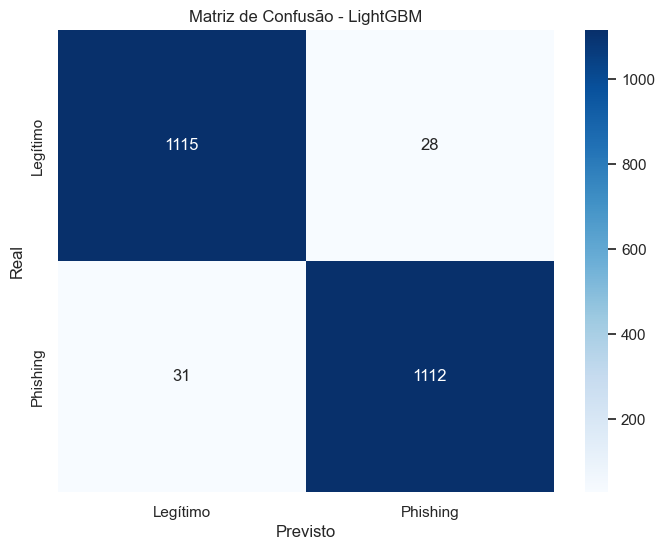

In [ ]:
# Matriz de confusão 
cm = confusion_matrix(y_test_final, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legítimo', 'Phishing'], yticklabels=['Legítimo', 'Phishing'])
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

## 1.6 Extra: Testando Redes neurais com TensorFlow/Keras

In [ ]:
def create_model(n_units1=128, n_units2=64, dropout_rate=0.3, lr=0.001):
    '''Rede Neural'''
    model = Sequential([
        Dense(n_units1, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(n_units2, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', AUC()])
    return model


In [ ]:
## Encontrando os melhores hiperparâmetros

# Empacotar o modelo
keras_clf = KerasClassifier(
    model=create_model, 
    verbose=0, 
    epochs=30, 
    batch_size=32)

# Espaço de busca dos hiperparâmetros
param_dist = {
    "model__n_units1": [64, 128, 256],
    "model__n_units2": [32, 64, 128],
    "model__dropout_rate": [0.2, 0.3, 0.4],
    "model__lr": [1e-2, 1e-3, 1e-4],
    "batch_size": [32, 64]
}



# EarlyStopping (aplicado dentro do fit do random_search)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)


# Random Search
random_search = RandomizedSearchCV(
    keras_clf,
    param_distributions=param_dist,
    cv=3,  # ou usar uma validação simples com validation_data, se preferir
    n_iter=10,
    verbose=1,
    n_jobs=1  # Se der erro com n_jobs=-1 em Keras, mude para 1
)



# Melhores hiperparâmetros
random_search.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

best_model = random_search.best_estimator_



Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
# Extrai os melhores hiperparâmetros
best_params = random_search.best_params_

# Criar o modelo final usando os hiperparâmetros ótimos
model_final = create_model(
    n_units1=best_params["model__n_units1"],
    n_units2=best_params["model__n_units2"],
    dropout_rate=best_params["model__dropout_rate"],
    lr=best_params["model__lr"]
)

best_model

KerasClassifier(
	model=<function create_model at 0x000002222F808550>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=30
	class_weight=None
	model__n_units2=128
	model__n_units1=128
	model__lr=0.001
	model__dropout_rate=0.3
)

<Sequential name=sequential_32, built=True>
Epoch 1/50
229/229 - 3s - 14ms/step - accuracy: 0.8824 - auc_34: 0.9524 - loss: 0.2836 - val_accuracy: 0.9470 - val_auc_34: 0.9851 - val_loss: 0.1560
Epoch 2/50
229/229 - 1s - 4ms/step - accuracy: 0.9306 - auc_34: 0.9785 - loss: 0.1869 - val_accuracy: 0.9535 - val_auc_34: 0.9876 - val_loss: 0.1349
Epoch 3/50
229/229 - 1s - 4ms/step - accuracy: 0.9419 - auc_34: 0.9843 - loss: 0.1557 - val_accuracy: 0.9546 - val_auc_34: 0.9884 - val_loss: 0.1295
Epoch 4/50
229/229 - 1s - 4ms/step - accuracy: 0.9482 - auc_34: 0.9870 - loss: 0.1416 - val_accuracy: 0.9552 - val_auc_34: 0.9888 - val_loss: 0.1296
Epoch 5/50
229/229 - 1s - 4ms/step - accuracy: 0.9493 - auc_34: 0.9877 - loss: 0.1387 - val_accuracy: 0.9546 - val_auc_34: 0.9885 - val_loss: 0.1326
Epoch 6/50
229/229 - 1s - 4ms/step - accuracy: 0.9526 - auc_34: 0.9896 - loss: 0.1252 - val_accuracy: 0.9601 - val_auc_34: 0.9895 - val_loss: 0.1252
Epoch 7/50
229/229 - 1s - 4ms/step - accuracy: 0.9553 - auc_3

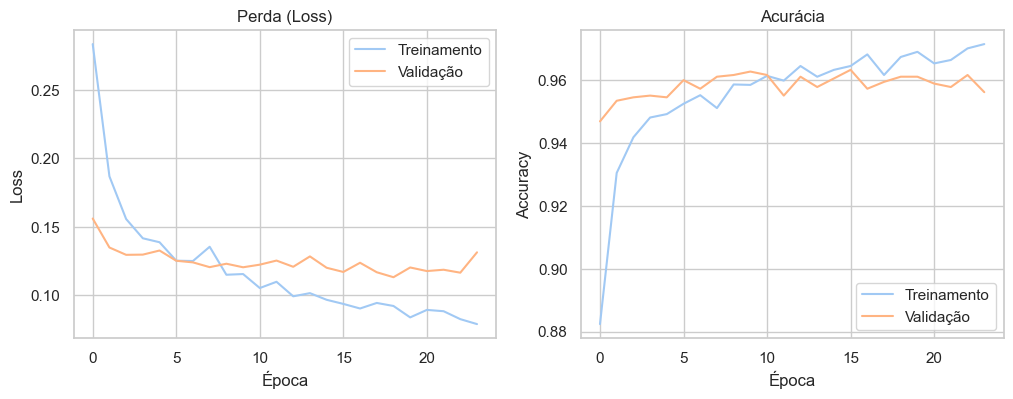

In [ ]:
## Analisando o comportamento (overfitting, underfitting)

# Juntar treino e validação
X_trainval = np.vstack([X_train, X_val])
y_trainval = np.hstack([y_train, y_val])

# Criar novo modelo com os melhores hiperparâmetros
model_nn = create_model(
    n_units1=best_model.get_params()["model__n_units1"],
    n_units2=best_model.get_params()["model__n_units2"],
    dropout_rate=best_model.get_params()["model__dropout_rate"],
    lr=best_model.get_params()["model__lr"]
)

print(model_nn)

model_nn.compile(optimizer=Adam(learning_rate=best_model.get_params()["model__lr"]),
                 loss="binary_crossentropy", metrics=["accuracy", AUC()])

# Treinamento com split para gráfico
history = model_nn.fit(
    X_trainval, y_trainval,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=2
)



#Grafico

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda (Loss)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
##  Treinar modelo final e avaliar no conjunto de teste

# Treinar modelo final com tudo
model_final = create_model(
    n_units1=best_model.get_params()["model__n_units1"],
    n_units2=best_model.get_params()["model__n_units2"],
    dropout_rate=best_model.get_params()["model__dropout_rate"],
    lr=best_model.get_params()["model__lr"]
)

model_final.compile(optimizer=Adam(learning_rate=best_model.get_params()["model__lr"]),
                    loss="binary_crossentropy", metrics=["accuracy", AUC()])

model_final.fit(
    X_trainval, y_trainval,
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)],
    verbose=2
)


Epoch 1/50
286/286 - 2s - 9ms/step - accuracy: 0.8942 - auc_38: 0.9596 - loss: 0.2606
Epoch 2/50
286/286 - 1s - 3ms/step - accuracy: 0.9377 - auc_38: 0.9809 - loss: 0.1718
Epoch 3/50
286/286 - 1s - 3ms/step - accuracy: 0.9434 - auc_38: 0.9850 - loss: 0.1512
Epoch 4/50
286/286 - 1s - 3ms/step - accuracy: 0.9475 - auc_38: 0.9867 - loss: 0.1428
Epoch 5/50
286/286 - 1s - 3ms/step - accuracy: 0.9520 - auc_38: 0.9883 - loss: 0.1320
Epoch 6/50
286/286 - 1s - 5ms/step - accuracy: 0.9534 - auc_38: 0.9888 - loss: 0.1297
Epoch 7/50
286/286 - 1s - 4ms/step - accuracy: 0.9567 - auc_38: 0.9909 - loss: 0.1181
Epoch 8/50
286/286 - 1s - 3ms/step - accuracy: 0.9547 - auc_38: 0.9901 - loss: 0.1208
Epoch 9/50
286/286 - 1s - 3ms/step - accuracy: 0.9542 - auc_38: 0.9903 - loss: 0.1213
Epoch 10/50
286/286 - 1s - 3ms/step - accuracy: 0.9590 - auc_38: 0.9921 - loss: 0.1076
Epoch 11/50
286/286 - 1s - 3ms/step - accuracy: 0.9634 - auc_38: 0.9921 - loss: 0.1061
Epoch 12/50
286/286 - 1s - 3ms/step - accuracy: 0.96

In [ ]:
# Avaliar no teste
test_preds_proba = model_final.predict(X_test_final)
test_preds = (test_preds_proba > 0.5).astype(int)



# Métricas
test_f1 = f1_score(y_test_final, test_preds)
test_precision = precision_score(y_test_final, test_preds)
test_recall = recall_score(y_test_final, test_preds)
test_accuracy = accuracy_score(y_test_final, test_preds)

if hasattr(best_model, "predict_proba"): # AUC requer probabilidades se for binário
    test_probs = best_model.predict_proba(X_test_final)[:, 1]
    test_auc = roc_auc_score(y_test_final, test_probs)
else:
    test_auc = roc_auc_score(y_test_final, test_preds)  # fallback para decision function ou labels


print(f"F1-score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"AUC: {test_auc:.4f}")

print(f"Matriz de Confusão:")
print(confusion_matrix(y_test_final, test_preds))


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
F1-score: 0.9635
Precision: 0.9569
Recall: 0.9703
Accuracy: 0.9633
AUC: 0.9928
Matriz de Confusão:
[[1093   50]
 [  34 1109]]


# Etapa 2 - CNNs Aplicadas às URLs Originais

Modelos de redes neurais convolucionais (CNNs) têm se mostrado eficazes na detecção de phishing a partir das características estruturais da URL, sem a necessidade de features manuais. Nessa etapa, trabalhamos exclusivamente com a URL bruta, transformando-a em uma sequência de caracteres para entrada na CNN.

Além do dataset “Web Page Phishing Detection Dataset” (df_dataset1) usado na Etapa 1, aqui vamos usar outros 2 datasets: "Phishing and Benign Websites Dataset" (df_dataset2) e "PhiUSIIL Phishing URL (Website)" (df_dataset3).


In [ ]:
## Funções

def etapa2_tratamentos(df, url, label, label_0, label_1, max_len):
    '''Tratamentos e Padronização'''

    df.rename(columns={label: 'status', url: 'url'}, inplace=True)

    # "url" 
    urls = df['url'].astype(str).tolist()

    # "status" (0 = legítimo, 1 = phishing)
    if label_1 != 1:
        df['status'] = df['status'].astype(str).str.lower()
        df['status'] = df['status'].apply(lambda x: 1 if label_1 in x else 0)


    df_1 = df[df['status'] == 1] 
    df_0 = df[df['status'] == 0] 

    # Padronização
    if len(df_1)>len(df_0):
        df_majority_downsampled = resample(df_1, 
                                        replace=False, 
                                        n_samples=len(df_0), 
                                        random_state=42)
        df_padron = pd.concat([df_majority_downsampled, df_0])
        df_padron = df_padron.sample(frac=1, random_state=42).reset_index(drop=True)
    
    elif len(df_1)<len(df_0):        
        df_majority_downsampled = resample(df_0, 
                                        replace=False, 
                                        n_samples=len(df_1), 
                                        random_state=42)
        df_padron = pd.concat([df_majority_downsampled, df_1])
        df_padron = df_padron.sample(frac=1, random_state=42).reset_index(drop=True)

    else:
        df_padron = df.copy()


    labels = df["status"].values


    # Tokenização de caracteres 
    tokenizer = Tokenizer(char_level=True)
    tokenizer.fit_on_texts(urls)
    vocab_size = len(tokenizer.word_index) + 1

    # Transforma cada URL em uma sequência de índices
    sequences = tokenizer.texts_to_sequences(urls)

    # Padding para ter todas as sequências com mesmo comprimento
    max_len = max_len 
    X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    y = np.array(labels)

    return X, y, urls, tokenizer, vocab_size


def build_model(hp):
    '''Rede convolucional com hiperparâmetros para tuning'''
    
    model = Sequential()
    
    # Camada de embedding que transforma índices dos caracteres em vetores densos
    # O tamanho do vetor é um hiperparâmetro que varia de 32 a 128, em passos de 32
    model.add(Embedding(vocab_size, hp.Int('embedding_dim', 32, 128, step=32), input_length=max_len))
    
    # Camada convolucional 1D
    # O número de filtros é um hiperparâmetro entre 64 e 256, passo 64
    # O tamanho do kernel (filtro) é escolhido entre 3, 5 ou 7
    # A ativação é ReLU
    model.add(Conv1D(filters=hp.Int('filters', 64, 256, step=64),
                     kernel_size=hp.Choice('kernel_size', [3, 5, 7]),
                     activation='relu'))
    
    # GlobalMaxPooling pega o maior valor de cada filtro (reduz dimensionalidade)
    model.add(GlobalMaxPooling1D())
    
    # Camada densa com 64 neurônios e ativação ReLU
    model.add(Dense(64, activation='relu'))
    
    # Dropout para evitar overfitting, taxa entre 0.3 e 0.6 (hiperparâmetro)
    model.add(Dropout(hp.Float('dropout', 0.3, 0.6, step=0.1)))
    
    # Camada de saída com 1 neurônio (binário) e ativação sigmóide para probabilidade
    model.add(Dense(1, activation='sigmoid'))
    
    # Compila o modelo usando otimizador Adam e função de perda binária
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


## 2.1 Web Page Phishing Detection Dataset

In [ ]:
max_len = 200 # comprimento para as urls
df_dataset1_copy = df_dataset1.copy() 
print(df_dataset1_copy.shape)
X, y, urls, tokenizer, vocab_size =  etapa2_tratamentos(df_dataset1_copy, "url", "status", 'legitimate', 'phishing', max_len)



(11430, 89)


In [ ]:
# Separação dos dados em treino, validação e teste
X_train, X_temp, y_train, y_temp, urls_train, urls_temp = train_test_split(X, y, urls,  test_size=0.3, stratify=y, random_state=42)
X_val, X_test_1, y_val, y_test_1, urls_val, urls_test_1 = train_test_split(X_temp, y_temp, urls_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))
print(np.unique(y_test_1, return_counts=True))
print(np.unique(urls_test_1, return_counts=True))


(array([0, 1]), array([4000, 4001]))
(array([0, 1]), array([857, 857]))
(array([0, 1]), array([858, 857]))
(array(['http://02dfbe20-6956-4be6-ba22-36ae0e0d3053.htmlcomponentservice.com/get_draft?id=99ea0e_8eddaa8b0b3b6316a653bbd03eb5b48f.html',
       'http://03418f6.netsolhost.com/FF7AADF203DF6C7A0B7C8A74B8164E55/?sec=Milka%20Gostovic',
       'http://03418f6.netsolhost.com/FF7AADF203DF6C7A0B7C8A74B8164E55/?sec=PucKotsis',
       ..., 'https://yogamma.com.tr/usa.html',
       'https://zgz5b.codesandbox.io/', 'https://zmail221.appspot.com'],
      dtype='<U557'), array([1, 1, 1, ..., 1, 1, 1]))


In [ ]:
# Configuração do RandomSearch para busca dos melhores hiperparâmetros
tuner = RandomSearch(
    build_model,               
    objective='val_accuracy',  # objetivo: maximizar a acurácia na validação
    max_trials=10,             # número máximo de combinações aleatórias a testar
    executions_per_trial=1,    # executa cada configuração 1 vez
    directory='tuning',        # pasta onde os resultados serão salvos
    project_name='phishing_model1'  # nome do projeto para organização dos resultados
)

# Inicia a busca com os dados de treino e validação
tuner.search(
    X_train, y_train, 
    validation_data=(X_val, y_val), 
    epochs=10, batch_size=32
)

Reloading Tuner from tuning\phishing_model1\tuner0.json


In [ ]:
# Melhores hiperparâmetros
best_hp = tuner.get_best_hyperparameters(1)[0]

print("Melhores hiperparâmetros encontrados:")
print(f"embedding_dim: {best_hp.get('embedding_dim')}")
print(f"filters: {best_hp.get('filters')}")
print(f"kernel_size: {best_hp.get('kernel_size')}")
print(f"dropout: {best_hp.get('dropout')}")


Melhores hiperparâmetros encontrados:
embedding_dim: 96
filters: 192
kernel_size: 5
dropout: 0.5


In [ ]:
# Constrói o modelo com os melhores hiperparâmetros
best_model = build_model(best_hp)

# pesos de classe
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))


# Callback para parar o treino se a validação não melhorar por 3 épocas seguidas
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)


# Treina o modelo (você pode ajustar épocas, batch size, callbacks)
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights, 
    verbose=2
)


Epoch 1/20
251/251 - 75s - 297ms/step - accuracy: 0.7882 - loss: 0.4613 - val_accuracy: 0.8658 - val_loss: 0.3095
Epoch 2/20
251/251 - 37s - 149ms/step - accuracy: 0.8849 - loss: 0.2826 - val_accuracy: 0.9049 - val_loss: 0.2357
Epoch 3/20
251/251 - 41s - 162ms/step - accuracy: 0.9188 - loss: 0.2067 - val_accuracy: 0.9294 - val_loss: 0.1889
Epoch 4/20
251/251 - 59s - 234ms/step - accuracy: 0.9416 - loss: 0.1613 - val_accuracy: 0.9172 - val_loss: 0.2159
Epoch 5/20
251/251 - 45s - 181ms/step - accuracy: 0.9623 - loss: 0.1056 - val_accuracy: 0.9148 - val_loss: 0.2221
Epoch 6/20
251/251 - 47s - 189ms/step - accuracy: 0.9736 - loss: 0.0804 - val_accuracy: 0.9072 - val_loss: 0.2602
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


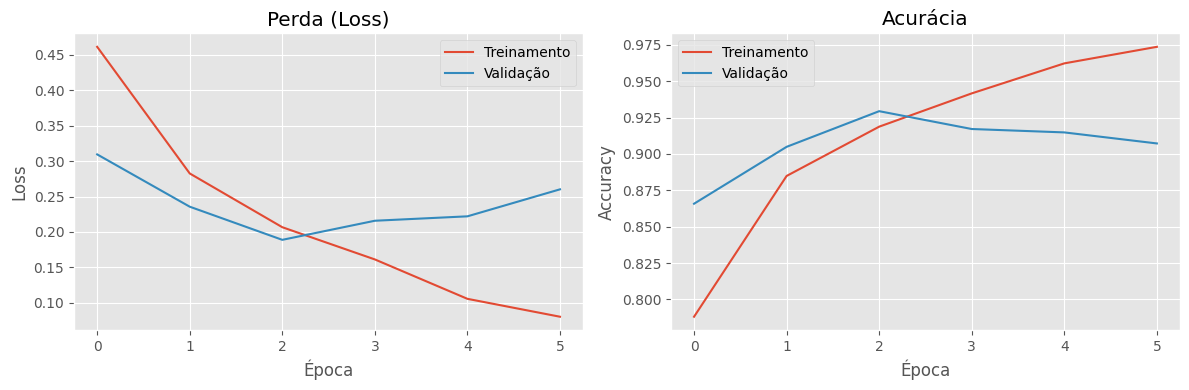

In [ ]:
# Agora sim, gera os gráficos que você colocou para Loss e Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda (Loss)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Junta treino e validação
X_train_final = np.concatenate((X_train, X_val))
y_train_final = np.concatenate((y_train, y_val))



# Reconstrói o modelo
final_model = build_model(best_hp)

# Recalcula os pesos de classe
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_final),
    y=y_train_final
)
class_weights = dict(enumerate(class_weights))


# EarlyStopping para evitar overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Treina o modelo final
final_model.fit(
    X_train_final, y_train_final,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=2
)


Epoch 1/20
243/243 - 53s - 220ms/step - accuracy: 0.7829 - loss: 0.4642 - val_accuracy: 0.8718 - val_loss: 0.3022
Epoch 2/20
243/243 - 42s - 173ms/step - accuracy: 0.8829 - loss: 0.2855 - val_accuracy: 0.9089 - val_loss: 0.2303
Epoch 3/20
243/243 - 76s - 312ms/step - accuracy: 0.9238 - loss: 0.2039 - val_accuracy: 0.9151 - val_loss: 0.2164
Epoch 4/20
243/243 - 35s - 145ms/step - accuracy: 0.9436 - loss: 0.1520 - val_accuracy: 0.9254 - val_loss: 0.1970
Epoch 5/20
243/243 - 26s - 108ms/step - accuracy: 0.9614 - loss: 0.1156 - val_accuracy: 0.9238 - val_loss: 0.2069
Epoch 6/20
243/243 - 27s - 110ms/step - accuracy: 0.9725 - loss: 0.0785 - val_accuracy: 0.9099 - val_loss: 0.2436
Epoch 7/20
243/243 - 28s - 115ms/step - accuracy: 0.9826 - loss: 0.0585 - val_accuracy: 0.9213 - val_loss: 0.2694


In [ ]:
# Avaliação final no conjunto de teste
y_pred_prob = final_model.predict(X_test_1)
y_pred_label = (y_pred_prob > 0.5).astype(int)

 
# Métricas
test_f1 = f1_score(y_test_1, y_pred_label)
test_precision = precision_score(y_test_1, y_pred_label)
test_recall = recall_score(y_test_1, y_pred_label)
test_accuracy = accuracy_score(y_test_1, y_pred_label)

print(f"F1-score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")

print(f"Matriz de Confusão:")
print(confusion_matrix(y_test_1, y_pred_label))


54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
F1-score: 0.9307
Precision: 0.9535
Recall: 0.9090
Accuracy: 0.9324
Matriz de Confusão:
[[820  38]
 [ 78 779]]


In [ ]:
# Estrutura do modelo e pesos
final_model.save("phishing_model_1.h5")


## 2.2 Phishing and Benign Websites Dataset

In [ ]:
max_len = 200 # comprimento para as urls
df_dataset2_copy = df_dataset2.copy() 
print(df_dataset2_copy.shape)

X, y, urls, tokenizer2, vocab_size = etapa2_tratamentos(df_dataset2_copy, "URLs", "Label", 'benign', 'phishing', max_len)

(38800, 2)


In [ ]:
# Separação dos dados em treino, validação e teste
X_train, X_temp, y_train, y_temp, urls_train, urls_temp = train_test_split(X, y, urls, test_size=0.3, stratify=y, random_state=42)
X_val, X_test_2, y_val, y_test_2, urls_val, urls_test_2 = train_test_split(X_temp, y_temp, urls_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))
print(np.unique(y_test_2, return_counts=True))
print(np.unique(urls_test_2, return_counts=True))

(array([0, 1]), array([13580, 13580]))
(array([0, 1]), array([2910, 2910]))
(array([0, 1]), array([2910, 2910]))
(array(['http://www.000p4en.wcomhost.com/Ameli-Assurance/remboursement/login/iframe-page2.html',
       'http://www.0292983393902020.efreehost.com/Welcome/Welcome.html',
       'http://www.03418f6.netsolhost.com/FF7AADF203DF6C7A0B7C8A74B8164E55/?sec=PucKotsis',
       ..., 'https://www.zonaseguraslbperu.com/',
       'https://www.ztsmcjrucvtkfkjmeb.top/',
       'https://www.zxdubljsdpwtjzrsxivczvdhgfvllzyfuucf-dot-cedar-code-289917.nn.r.appspot.com/'],
      dtype='<U939'), array([1, 1, 1, ..., 1, 1, 1]))


In [ ]:
# Busca dos melhores hiperparâmetros
tuner = RandomSearch(
    build_model,               
    objective='val_accuracy',  # objetivo: maximizar a acurácia na validação
    max_trials=10,             # número máximo de combinações aleatórias a testar
    executions_per_trial=1,    # executa cada configuração 1 vez
    directory='tuning',        # pasta onde os resultados serão salvos
    project_name='phishing_model2'  # nome do projeto para organização dos resultados
)

# Inicia a busca com os dados de treino e validação
tuner.search(
    X_train, y_train, 
    validation_data=(X_val, y_val), 
    epochs=10, batch_size=32
)

Reloading Tuner from tuning\phishing_model2\tuner0.json


In [ ]:
# Melhores hiperparâmetros
best_hp = tuner.get_best_hyperparameters(1)[0]

print("Melhores hiperparâmetros encontrados:")
print(f"embedding_dim: {best_hp.get('embedding_dim')}")
print(f"filters: {best_hp.get('filters')}")
print(f"kernel_size: {best_hp.get('kernel_size')}")
print(f"dropout: {best_hp.get('dropout')}")


Melhores hiperparâmetros encontrados:
embedding_dim: 128
filters: 256
kernel_size: 7
dropout: 0.5


In [ ]:
# Constrói o modelo com os melhores hiperparâmetros
best_model = build_model(best_hp)

# pesos de classe
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))


# Callback para parar o treino se a validação não melhorar por 3 épocas seguidas
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)


# Treina o modelo (você pode ajustar épocas, batch size, callbacks)
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights, 
    verbose=2
)


Epoch 1/20
849/849 - 104s - 123ms/step - accuracy: 0.9059 - loss: 0.2253 - val_accuracy: 0.9515 - val_loss: 0.1251
Epoch 2/20
849/849 - 76s - 90ms/step - accuracy: 0.9578 - loss: 0.1132 - val_accuracy: 0.9595 - val_loss: 0.1052
Epoch 3/20
849/849 - 77s - 91ms/step - accuracy: 0.9694 - loss: 0.0800 - val_accuracy: 0.9598 - val_loss: 0.0995
Epoch 4/20
849/849 - 75s - 88ms/step - accuracy: 0.9781 - loss: 0.0597 - val_accuracy: 0.9620 - val_loss: 0.0987
Epoch 5/20
849/849 - 78s - 92ms/step - accuracy: 0.9837 - loss: 0.0438 - val_accuracy: 0.9656 - val_loss: 0.0970
Epoch 6/20
849/849 - 77s - 90ms/step - accuracy: 0.9874 - loss: 0.0374 - val_accuracy: 0.9632 - val_loss: 0.1065
Epoch 7/20
849/849 - 74s - 87ms/step - accuracy: 0.9895 - loss: 0.0328 - val_accuracy: 0.9631 - val_loss: 0.1154
Epoch 8/20
849/849 - 76s - 89ms/step - accuracy: 0.9909 - loss: 0.0253 - val_accuracy: 0.9471 - val_loss: 0.1539
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 5.


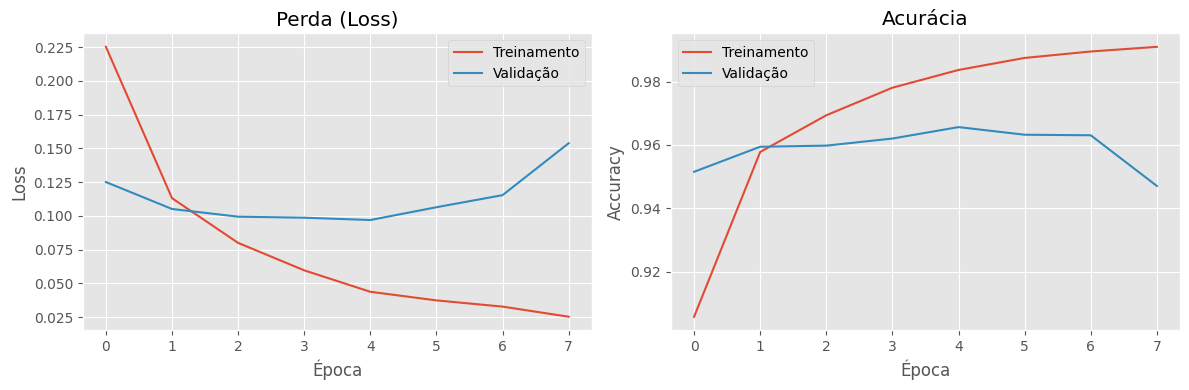

In [ ]:
# Agora sim, gera os gráficos que você colocou para Loss e Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda (Loss)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Junta treino e validação
X_train_final = np.concatenate((X_train, X_val))
y_train_final = np.concatenate((y_train, y_val))



# Reconstrói o modelo
final_model = build_model(best_hp)

# Recalcula os pesos de classe
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_final),
    y=y_train_final
)
class_weights = dict(enumerate(class_weights))


# EarlyStopping para evitar overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Treina o modelo final
final_model.fit(
    X_train_final, y_train_final,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=2
)


Epoch 1/20
825/825 - 86s - 104ms/step - accuracy: 0.9058 - loss: 0.2264 - val_accuracy: 0.9503 - val_loss: 0.1222
Epoch 2/20
825/825 - 75s - 91ms/step - accuracy: 0.9566 - loss: 0.1151 - val_accuracy: 0.9606 - val_loss: 0.0996
Epoch 3/20
825/825 - 75s - 91ms/step - accuracy: 0.9704 - loss: 0.0785 - val_accuracy: 0.9471 - val_loss: 0.1416
Epoch 4/20
825/825 - 75s - 91ms/step - accuracy: 0.9756 - loss: 0.0642 - val_accuracy: 0.9671 - val_loss: 0.0888
Epoch 5/20
825/825 - 76s - 92ms/step - accuracy: 0.9823 - loss: 0.0470 - val_accuracy: 0.9642 - val_loss: 0.1099
Epoch 6/20
825/825 - 80s - 97ms/step - accuracy: 0.9867 - loss: 0.0361 - val_accuracy: 0.9656 - val_loss: 0.1051
Epoch 7/20
825/825 - 80s - 97ms/step - accuracy: 0.9887 - loss: 0.0315 - val_accuracy: 0.9642 - val_loss: 0.1206


In [ ]:
# Avaliação final no conjunto de teste
y_pred_prob = final_model.predict(X_test_2)
y_pred_label = (y_pred_prob > 0.5).astype(int)

# Métricas
test_f1 = f1_score(y_test_2, y_pred_label)
test_precision = precision_score(y_test_2, y_pred_label)
test_recall = recall_score(y_test_2, y_pred_label)
test_accuracy = accuracy_score(y_test_2, y_pred_label)

print(f"F1-score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")

print(f"Matriz de Confusão:")
print(confusion_matrix(y_test_2, y_pred_label))


182/182 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
F1-score: 0.9616
Precision: 0.9766
Recall: 0.9471
Accuracy: 0.9622
Matriz de Confusão:
[[2844   66]
 [ 154 2756]]


In [ ]:
# Estrutura do modelo e pesos
final_model.save("phishing_model_2.h5")


## 2.3 PhiUSIIL Phishing URL (Website)

In [ ]:
# Tratativa para pradronizaar como os outros dataframes onde 1 é phishing e 0 é legitimo
df_dataset3['label'] = 1 - df_dataset3['label']
df_dataset3['label'].value_counts()


label
0    134850
1    100945
Name: count, dtype: int64

In [ ]:
max_len = 200 # comprimento para as urls
df_dataset3_copy = df_dataset3.copy() 
print(df_dataset3_copy.shape)

X, y, urls, tokenizer3, vocab_size =  etapa2_tratamentos(df_dataset3_copy, "URL", "label", 0, 1, max_len)  


(235795, 56)


In [ ]:
# Separação dos dados em treino, validação e teste

X_train, X_temp, y_train, y_temp, urls_train, urls_temp = train_test_split(
    X, y, urls, test_size=0.3, stratify=y, random_state=42
)

X_val, X_test_3, y_val, y_test_3, urls_val, urls_test_3 = train_test_split(
    X_temp, y_temp, urls_temp, test_size=0.5, stratify=y_temp, random_state=42
)


print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))
print(np.unique(y_test_3, return_counts=True))
print(np.unique(urls_test_3, return_counts=True))

(array([0, 1]), array([94395, 70661]))
(array([0, 1]), array([20227, 15142]))
(array([0, 1]), array([20228, 15142]))
(array(['http://00000pf.ibizaeu.info/', 'http://005650.atsnx.com/?i=1',
       'http://010auth0.duckdns.org/index2.html', ...,
       'https://zukaz.info/@@/', 'https://zv8b-kg8v.web.app/',
       'https://zxcwtgs.asdwet.repl.co/'], dtype='<U5795'), array([1, 1, 1, ..., 1, 1, 1]))


In [ ]:
# Busca dos melhores hiperparâmetros
tuner = RandomSearch(
    build_model,               
    objective='val_accuracy',  # objetivo: maximizar a acurácia na validação
    max_trials=10,             # número máximo de combinações aleatórias a testar
    executions_per_trial=1,    # executa cada configuração 1 vez
    directory='tuning',        # pasta onde os resultados serão salvos
    project_name='phishing_model3'  # nome do projeto para organização dos resultados
)

tuner.search(
    X_train, y_train, 
    validation_data=(X_val, y_val), 
    epochs=10, batch_size=32
)

Reloading Tuner from tuning\phishing_model3\tuner0.json


In [ ]:
# Melhores hiperparâmetros
best_hp = tuner.get_best_hyperparameters(1)[0]


print("Melhores hiperparâmetros encontrados:")
print(f"embedding_dim: {best_hp.get('embedding_dim')}")
print(f"filters: {best_hp.get('filters')}")
print(f"kernel_size: {best_hp.get('kernel_size')}")
print(f"dropout: {best_hp.get('dropout')}")


Melhores hiperparâmetros encontrados:
embedding_dim: 128
filters: 128
kernel_size: 5
dropout: 0.5


In [ ]:
# Constrói o modelo com os melhores hiperparâmetros
best_model = build_model(best_hp)

# pesos de classe
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))


# Callback para parar o treino se a validação não melhorar por 3 épocas seguidas
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)


# Treina o modelo (você pode ajustar épocas, batch size, callbacks)
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights, 
    verbose=2
)


Epoch 1/20
5158/5158 - 98s - 19ms/step - accuracy: 0.9964 - loss: 0.0228 - val_accuracy: 0.9974 - val_loss: 0.0157
Epoch 2/20
5158/5158 - 99s - 19ms/step - accuracy: 0.9978 - loss: 0.0159 - val_accuracy: 0.9978 - val_loss: 0.0191
Epoch 3/20
5158/5158 - 95s - 18ms/step - accuracy: 0.9980 - loss: 0.0142 - val_accuracy: 0.9981 - val_loss: 0.0127
Epoch 4/20
5158/5158 - 92s - 18ms/step - accuracy: 0.9981 - loss: 0.0131 - val_accuracy: 0.9978 - val_loss: 0.0132
Epoch 5/20
5158/5158 - 103s - 20ms/step - accuracy: 0.9982 - loss: 0.0125 - val_accuracy: 0.9981 - val_loss: 0.0118
Epoch 6/20
5158/5158 - 92s - 18ms/step - accuracy: 0.9983 - loss: 0.0119 - val_accuracy: 0.9980 - val_loss: 0.0140
Epoch 7/20
5158/5158 - 93s - 18ms/step - accuracy: 0.9984 - loss: 0.0112 - val_accuracy: 0.9979 - val_loss: 0.0139
Epoch 8/20
5158/5158 - 92s - 18ms/step - accuracy: 0.9983 - loss: 0.0106 - val_accuracy: 0.9977 - val_loss: 0.0147
Epoch 8: early stopping
Restoring model weights from the end of the best epoch:

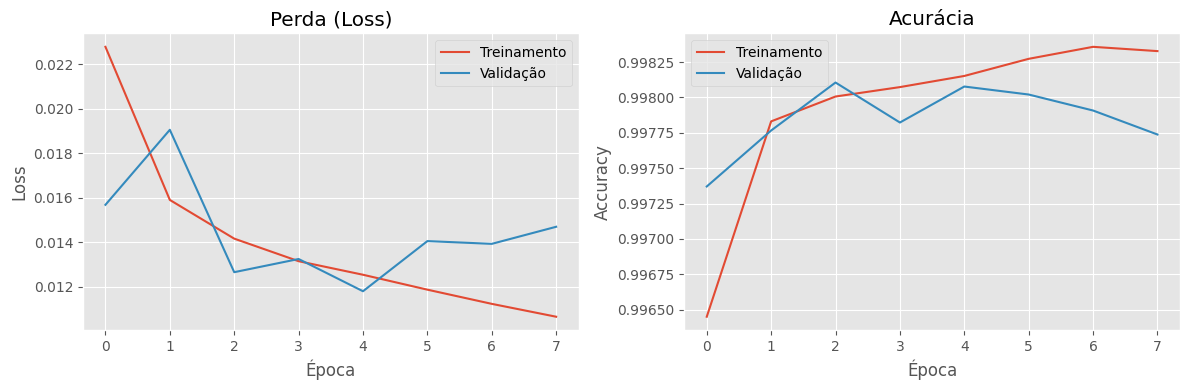

In [ ]:
# Agora sim, gera os gráficos que você colocou para Loss e Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda (Loss)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Junta treino e validação
X_train_final = np.concatenate((X_train, X_val))
y_train_final = np.concatenate((y_train, y_val))



# Reconstrói o modelo
final_model = build_model(best_hp)

# Recalcula os pesos de classe
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_final),
    y=y_train_final
)
class_weights = dict(enumerate(class_weights))


# EarlyStopping para evitar overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Treina o modelo final
final_model.fit(
    X_train_final, y_train_final,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=2
)


Epoch 1/20
5011/5011 - 91s - 18ms/step - accuracy: 0.9965 - loss: 0.0227 - val_accuracy: 0.9978 - val_loss: 0.0159
Epoch 2/20
5011/5011 - 89s - 18ms/step - accuracy: 0.9980 - loss: 0.0153 - val_accuracy: 0.9978 - val_loss: 0.0137
Epoch 3/20
5011/5011 - 92s - 18ms/step - accuracy: 0.9980 - loss: 0.0141 - val_accuracy: 0.9979 - val_loss: 0.0142
Epoch 4/20
5011/5011 - 92s - 18ms/step - accuracy: 0.9982 - loss: 0.0128 - val_accuracy: 0.9979 - val_loss: 0.0129
Epoch 5/20
5011/5011 - 93s - 19ms/step - accuracy: 0.9982 - loss: 0.0120 - val_accuracy: 0.9980 - val_loss: 0.0124
Epoch 6/20
5011/5011 - 91s - 18ms/step - accuracy: 0.9983 - loss: 0.0114 - val_accuracy: 0.9980 - val_loss: 0.0129
Epoch 7/20
5011/5011 - 90s - 18ms/step - accuracy: 0.9983 - loss: 0.0107 - val_accuracy: 0.9976 - val_loss: 0.0164
Epoch 8/20
5011/5011 - 90s - 18ms/step - accuracy: 0.9984 - loss: 0.0103 - val_accuracy: 0.9974 - val_loss: 0.0154


In [ ]:
# Avaliação final no conjunto de teste
y_pred_prob = final_model.predict(X_test_3)
y_pred_label = (y_pred_prob > 0.5).astype(int)

# Métricas
test_f1 = f1_score(y_test_3, y_pred_label)
test_precision = precision_score(y_test_3, y_pred_label)
test_recall = recall_score(y_test_3, y_pred_label)
test_accuracy = accuracy_score(y_test_3, y_pred_label)

print(f"F1-score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")

print(f"Matriz de Confusão:")
print(confusion_matrix(y_test_3, y_pred_label))


1106/1106 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
F1-score: 0.9979
Precision: 0.9999
Recall: 0.9960
Accuracy: 0.9982
Matriz de Confusão:
[[20226     2]
 [   60 15082]]


In [ ]:
# Estrutura do modelo e pesos
final_model.save("phishing_model_3.h5")


# Etapa 3 - Avaliação Adversarial: CNN com URLs Manipuladas

Nesta fase, simulamos ataques de engenharia adversarial ao modificar apenas as URLs de phishing no conjunto de teste de cada um dos 3 datasets, mantendo seus rótulos. O objetivo é verificar se o modelo treinado é capaz de identificar phishing mesmo com leves alterações enganosas.

In [ ]:
def insert_random_char(url):
    if len(url) == 0:
        return url
    pos = random.randint(0, len(url)-1)
    random_char = random.choice('abcdefghijklmnopqrstuvwxyz0123456789')
    return url[:pos] + random_char + url[pos:]

def delete_random_char(url):
    if len(url) <= 1:
        return url
    pos = random.randint(0, len(url)-1)
    return url[:pos] + url[pos+1:]

def swap_adjacent_chars(url):
    if len(url) <= 1:
        return url
    pos = random.randint(0, len(url)-2)
    return url[:pos] + url[pos+1] + url[pos] + url[pos+2:]

def replace_random_char(url):
    if len(url) == 0:
        return url
    pos = random.randint(0, len(url)-1)
    random_char = random.choice('abcdefghijklmnopqrstuvwxyz0123456789')
    return url[:pos] + random_char + url[pos+1:]



## 3.1 Web Page Phishing Detection Dataset

In [ ]:
# Caregar o modelo
model = load_model("phishing_model_1.h5")

In [ ]:
# Da etapa 2.1
max_len = 200
len(X_test_1), len(y_test_1), len(urls_test_1)

(1715, 1715, 1715)

In [ ]:
results = []

for url, label in zip(urls_test_1, y_test_1):
    if label == 1:  # Só URLs phishing
        perturbations = {
            "insert": insert_random_char(url),
            "delete": delete_random_char(url),
            "swap": swap_adjacent_chars(url),
            "replace": replace_random_char(url)
        }

        probs = {}
        for perturb_type, perturbed_url in perturbations.items():
            # Pré-processa a URL para o modelo
            X_test = tokenizer.texts_to_sequences([perturbed_url])
            X_test = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')
            pred = model.predict(X_test, verbose=0)[0][0]  # Probabilidade da classe 1 (phishing)

            probs[perturb_type] = (perturbed_url, pred)

        # Escolhe a perturbação que mais derrubou a probabilidade da classe phishing
        best_attack_type = min(probs, key=lambda k: probs[k][1])
        best_url, best_prob = probs[best_attack_type]

        results.append({
            "URL_Original": url,
            "Perturbacao": best_attack_type,
            "URL_Perturbada": best_url,
            "Prob_Classe_1": best_prob,
        })


df_results = pd.DataFrame(results)

In [ ]:
df_results

,URL_Original,Perturbacao,URL_Perturbada,Prob_Classe_1
0,https://drive.google.com/file/d/1Ek__rSuML6v9E...,replace,https://drive.google.comrfile/d/1Ek__rSuML6v9E...,0.936982
1,http://grandbettinggir1.blogspot.com,insert,http://grandbettinggir1d.blogspot.com,0.921763
2,https://paypal-support-help-inc.blogspot.com/?m=0,insert,https://paypalv-support-help-inc.blogspot.com/...,0.926529
3,http://newsletter9707fb85e61e055593f03a43ab.dn...,swap,http://newsletter9707bf85e61e055593f03a43ab.dn...,0.997474
4,http://4d7255ca9b2659623.tempsite.link/Z62ESA3...,delete,http://4d7255ca9b2659623.tempsite.ink/Z62ESA3Z...,0.998529
...,...,...,...,...
852,https://part.eyrehead.com/bzp?kl=ZH9wlG9qbGKcl...,insert,https://part.eyrehead.com/bzp?kl=ZH9wlG9qbGKcl...,0.999719
853,http://ricado.9e.cz/nmp.html,insert,http://ricado.9e.cz/nmp.htm0l,0.974636
854,http://chachainsurance.com/wp-admin/includes/h...,insert,http://chachainsurance.com/wp-a7dmin/includes/...,0.999348
855,http://zaimlimit.ru/wp-content/themes/bin/Well...,swap,http://zaimlimit.ru/wp-content/themes/bin/Well...,0.999930


In [ ]:
urls_test_adv_final = []

# Um índice para percorrer os resultados de phishing
phishing_idx = 0

for url, label in zip(urls_test_1, y_test_1):
    if label == 1:
        # Pega a URL adversarial escolhida antes
        perturbed_url = results[phishing_idx]["URL_Perturbada"]
        urls_test_adv_final.append(perturbed_url)
        phishing_idx += 1
    else:
        # Mantém a URL legítima original
        urls_test_adv_final.append(url)


In [ ]:
X_test_adv = tokenizer.texts_to_sequences(urls_test_adv_final)
X_test_adv = pad_sequences(X_test_adv, maxlen=max_len, padding='post', truncating='post')


In [ ]:

y_pred_adv = model.predict(X_test_adv, verbose=0).flatten()
y_pred_label_adv = (y_pred_adv > 0.5).astype(int)

print("\n📉 Avaliação com URLs adversariais (phishing perturbado, legítimos originais):")
print(f"F1-score: {f1_score(y_test_1, y_pred_label_adv):.4f}")
print(f"Precision: {precision_score(y_test_1, y_pred_label_adv):.4f}")
print(f"Recall: {recall_score(y_test_1, y_pred_label_adv):.4f}")
print(f"Accuracy: {accuracy_score(y_test_1, y_pred_label_adv):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_1, y_pred_label_adv)}")


📉 Avaliação com URLs adversariais (phishing perturbado, legítimos originais):
F1-score: 0.9105
Precision: 0.9517
Recall: 0.8728
Accuracy: 0.9143
Confusion Matrix:
[[820  38]
 [109 748]]


### Comparação entre Dataset Original e Adversarial


| **Métrica**   | **Dataset Original** | **Dataset Adversarial** | **Variação**               |
|---------------|----------------------|-------------------------|----------------------------|
| **F1-score**  | 0.9307               | 0.9105                  | 🔻 Leve queda              |
| **Precision** | 0.9535               | 0.9517                  | 🔻 Queda muito pequena      |
| **Recall**    | 0.9090               | 0.8728                  | 🔻 Queda perceptível       |
| **Accuracy**  | 0.9324               | 0.9143                  | 🔻 Leve queda              |


### Observações:
- Mesmo com o ataque, o modelo manteve uma performance relativamente alta, mas **houve queda principalmente no Recall**, indicando que o modelo passou a deixar passar mais URLs phishing sem detectar.




## 3.2 Phishing and Benign Websites Dataset

In [7]:
# Caregar o modelo
model = load_model("phishing_model_2.h5")

In [10]:
# Da etapa 2.2
max_len = 200
print(len(X_test_2), len(y_test_2), len(urls_test_2))
tokenizer2

5820 5820 5820


In [11]:
results = []

for url, label in zip(urls_test_2, y_test_2):
    if label == 1:  # Só URLs phishing
        perturbations = {
            "insert": insert_random_char(url),
            "delete": delete_random_char(url),
            "swap": swap_adjacent_chars(url),
            "replace": replace_random_char(url)
        }

        probs = {}
        for perturb_type, perturbed_url in perturbations.items():
            # Pré-processa a URL para o modelo
            X_test = tokenizer2.texts_to_sequences([perturbed_url])
            X_test = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')
            pred = model.predict(X_test, verbose=0)[0][0]  # Probabilidade da classe 1 (phishing)

            probs[perturb_type] = (perturbed_url, pred)

        # Escolhe a perturbação que mais derrubou a probabilidade da classe phishing
        best_attack_type = min(probs, key=lambda k: probs[k][1])
        best_url, best_prob = probs[best_attack_type]

        results.append({
            "URL_Original": url,
            "Perturbacao": best_attack_type,
            "URL_Perturbada": best_url,
            "Prob_Classe_1": best_prob,
        })


df_results = pd.DataFrame(results)

In [12]:
df_results

,URL_Original,Perturbacao,URL_Perturbada,Prob_Classe_1
0,https://www.bookedandboarding.com/.tin/At&amp;...,swap,https://www.bookeadndboarding.com/.tin/At&amp;...,0.999997
1,https://www.pq-tk.pqrs.info/lao?bc=a4JwlXBicGK...,delete,https://www.pq-tk.pqrs.info/lao?bc=a4JwlXBicGK...,0.999999
2,https://www.accban-01003946.kahulasup.ch/appre...,insert,https://www.accban-01003946.kahulasup.ch/appre...,1.000000
3,http://www.santoorschool.com/.paypal-verificat...,swap,http://www.santoorschool.com/.papyal-verificat...,0.994914
4,http://www.groupwhattsap.jkub.com/,swap,http://www.groupwhattsap.jkub.com/,0.961901
...,...,...,...,...
2905,http://www.sunburstmedia.com/PronPower/=/Lbb-T...,insert,http://www.sunbursgtmedia.com/PronPower/=/Lbb-...,0.191166
2906,http://www.secure.runescape.com.gg-login.in/we...,swap,http://www.secure.runescape.com.gg-login.in/we...,1.000000
2907,https://www.forms.office.com/Pages/ResponsePag...,replace,https://www.forms.office.com/Pages/ResponsePag...,0.999953
2908,http://www.saltlakecitypetexpo.com/wp-content/...,insert,http://www.saltlakecitypetexpo.com/wp-content/...,1.000000


In [13]:
urls_test_adv_final = []

# Um índice para percorrer os resultados de phishing
phishing_idx = 0

for url, label in zip(urls_test_2, y_test_2):
    if label == 1:
        # Pega a URL adversarial escolhida antes
        perturbed_url = results[phishing_idx]["URL_Perturbada"]
        urls_test_adv_final.append(perturbed_url)
        phishing_idx += 1
    else:
        # Mantém a URL legítima original
        urls_test_adv_final.append(url)


In [15]:
X_test_adv = tokenizer2.texts_to_sequences(urls_test_adv_final)
X_test_adv = pad_sequences(X_test_adv, maxlen=max_len, padding='post', truncating='post')


In [17]:
y_pred_adv = model.predict(X_test_adv, verbose=0).flatten()
y_pred_label_adv = (y_pred_adv > 0.5).astype(int)

print("\n📉 Avaliação com URLs adversariais (phishing perturbado, legítimos originais):")
print(f"F1-score: {f1_score(y_test_2, y_pred_label_adv):.4f}")
print(f"Precision: {precision_score(y_test_2, y_pred_label_adv):.4f}")
print(f"Recall: {recall_score(y_test_2, y_pred_label_adv):.4f}")
print(f"Accuracy: {accuracy_score(y_test_2, y_pred_label_adv):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_2, y_pred_label_adv)}")


📉 Avaliação com URLs adversariais (phishing perturbado, legítimos originais):
F1-score: 0.9443
Precision: 0.9758
Recall: 0.9148
Accuracy: 0.9460
Confusion Matrix:
[[2844   66]
 [ 248 2662]]


### Comparação entre Dataset Original e Adversarial 
| **Métrica**   | **Dataset Original** | **Dataset Adversarial** | **Variação**               |
|---------------|----------------------|-------------------------|----------------------------|
| **F1-score**  | 0.9616               | 0.9443                  | 🔻 Leve queda              |
| **Precision** | 0.9766               | 0.9758                  | 🔻 Queda mínima            |
| **Recall**    | 0.9471               | 0.9148                  | 🔻 Queda mais perceptível  |
| **Accuracy**  | 0.9622               | 0.9460                  | 🔻 Leve queda              |



### Observações:
- O número de **falsos negativos (Phishing que o modelo não detectou)** aumentou de **154 para 248**, indicando que o ataque adversarial afetou principalmente a capacidade do modelo de detectar URLs phishing.
- Mesmo com a manipulação, o modelo manteve uma **alta precisão**, mas **perdeu recall**, ou seja, começou a errar mais na detecção de phishing.


## 3.3 PhiUSIIL Phishing URL (Website)

In [23]:
# Caregar o modelo
model = load_model("phishing_model_3.h5")

In [25]:
# Da etapa 2.3 
max_len = 200
print(len(X_test_3), len(y_test_3), len(urls_test_3))

tokenizer3

35370 35370 35370


In [26]:
results = []

for url, label in zip(urls_test_3, y_test_3):
    if label == 1:  # Só URLs phishing
        perturbations = {
            "insert": insert_random_char(url),
            "delete": delete_random_char(url),
            "swap": swap_adjacent_chars(url),
            "replace": replace_random_char(url)
        }

        probs = {}
        for perturb_type, perturbed_url in perturbations.items():
            # Pré-processa a URL para o modelo
            X_test = tokenizer3.texts_to_sequences([perturbed_url])
            X_test = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')
            pred = model.predict(X_test, verbose=0)[0][0]  # Probabilidade da classe 1 (phishing)

            probs[perturb_type] = (perturbed_url, pred)

        # Escolhe a perturbação que mais derrubou a probabilidade da classe phishing
        best_attack_type = min(probs, key=lambda k: probs[k][1])
        best_url, best_prob = probs[best_attack_type]

        results.append({
            "URL_Original": url,
            "Perturbacao": best_attack_type,
            "URL_Perturbada": best_url,
            "Prob_Classe_1": best_prob,
        })


df_results = pd.DataFrame(results)

In [27]:
df_results

,URL_Original,Perturbacao,URL_Perturbada,Prob_Classe_1
0,https://aoxnprtll.firebaseapp.com/,insert,https://aoxnpr0tll.firebaseapp.com/,1.0
1,http://azwerd.co.vu/suces.php,insert,http://azwerd.co.vu/souces.php,1.0
2,http://www.cloud.sicaogler.com,insert,http://www.cloud.sijcaogler.com,1.0
3,https://353232222.xyz/vmjddusx/third/7,insert,https://3532322225.xyz/vmjddusx/third/7,1.0
4,http://www.rcint.com,insert,htt9p://www.rcint.com,1.0
...,...,...,...,...
15137,http://3115tt.me/,insert,http:v//3115tt.me/,1.0
15138,https://aol-mail-104703.weeblysite.com/,insert,https://aol-mail-104703.weeblysitpe.com/,1.0
15139,http://www.cutt.ly/s3djrey/,insert,http://www.cutt.lny/s3djrey/,1.0
15140,http://www.lukkeze.club,insert,http://www.lukkeze.cluab,1.0


In [28]:
urls_test_adv_final = []

# Um índice para percorrer os resultados de phishing
phishing_idx = 0

for url, label in zip(urls_test_3, y_test_3):
    if label == 1:
        # Pega a URL adversarial escolhida antes
        perturbed_url = results[phishing_idx]["URL_Perturbada"]
        urls_test_adv_final.append(perturbed_url)
        phishing_idx += 1
    else:
        # Mantém a URL legítima original
        urls_test_adv_final.append(url)


In [29]:
X_test_adv = tokenizer3.texts_to_sequences(urls_test_adv_final)
X_test_adv = pad_sequences(X_test_adv, maxlen=max_len, padding='post', truncating='post')


In [30]:
y_pred_adv = model.predict(X_test_adv, verbose=0).flatten()
y_pred_label_adv = (y_pred_adv > 0.5).astype(int)

print("\n📉 Avaliação com URLs adversariais (phishing perturbado, legítimos originais):")
print(f"F1-score: {f1_score(y_test_3, y_pred_label_adv):.4f}")
print(f"Precision: {precision_score(y_test_3, y_pred_label_adv):.4f}")
print(f"Recall: {recall_score(y_test_3, y_pred_label_adv):.4f}")
print(f"Accuracy: {accuracy_score(y_test_3, y_pred_label_adv):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_3, y_pred_label_adv)}")


📉 Avaliação com URLs adversariais (phishing perturbado, legítimos originais):
F1-score: 0.9842
Precision: 0.9999
Recall: 0.9690
Accuracy: 0.9867
Confusion Matrix:
[[20226     2]
 [  470 14672]]


### Comparação entre Dataset Original e Adversarial

| **Métrica**   | **Dataset Original** | **Dataset Adversarial** | **Variação**               |
|---------------|----------------------|-------------------------|----------------------------|
| **F1-score**  | 0.9979               | 0.9842                  | 🔻 Pequena queda           |
| **Precision** | 0.9999               | 0.9999                  | 🔸 Igual      |
| **Recall**    | 0.9960               | 0.9690                  | 🔻 Queda perceptível       |
| **Accuracy**  | 0.9982               | 0.9867                  | 🔻 Leve queda              |


### Observações:
- O número de **falsos negativos** (phishing não detectado) subiu de **60 para 470**, indicando um **impacto direto na capacidade de detecção de phishing**.
- **Precisão permaneceu muito alta**, o que significa que o modelo continuou evitando falsos positivos, mas deixou passar mais phishing real.
